# Loads


In [1]:
!pip install pyro-ppl

     |████████████████████████████████| 522kB 3.5MB/s 


In [2]:
!nvidia-smi

Mon Jun 15 08:55:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [0]:
import matplotlib

In [0]:
# "Standard" imports
import numpy as np
from time import time
import itertools
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd

# Pytorch imports
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.distributions import TransformedDistribution

# Pyro imports
import pyro
from pyro.distributions import ConditionalTransformedDistribution, ConditionalTransformModule, TransformModule
import pyro.distributions as dist
from pyro.distributions.transforms import affine_coupling, affine_autoregressive, permute

# Sklearn imports
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

# Notebooks imports
from IPython.display import Image, display, clear_output
from tqdm import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual





In [0]:
%matplotlib inline

In [6]:
from google.colab import drive
import sys
import os
drive.mount('/content/drive/')
root_path = 'drive/My Drive/Colab_Notebooks/normalizingflows'
trained_flows_folder = 'drive/My Drive/Colab_Notebooks/normalizingflows/trained_flows'
dataset_folder = 'drive/My Drive/Colab_Notebooks/normalizingflows/datasets'
sys.path.append(root_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [7]:
%cd drive/'My Drive'/Thesis/code/DEwNF/
!git pull
%cd /content/

/content/drive/My Drive/Thesis/code/DEwNF
Already up to date.
/content


In [0]:
git_folder_path = 'drive/My Drive/Thesis/code/DEwNF/'
sys.path.append(git_folder_path)

In [0]:
from DEwNF.flows import ConditionalAffineCoupling, ConditionedAffineCoupling, ConditionalNormalizingFlowWrapper, conditional_affine_coupling
from DEwNF.utils import plot_4_contexts_cond_flow, plot_loss, sliding_plot_loss, plot_samples
from DEwNF.samplers import RotatingTwoMoonsConditionalSampler
from DEwNF.flows import ConditionalNormalizingFlowWrapper, ConditionalAffineCoupling

# Load data

In [0]:
two_moons_folder = os.path.join(dataset_folder, 'two_moons')
csv_path = os.path.join(two_moons_folder, 'rotating_two_moons_no_moon_100k_n005.csv')
data_df = pd.read_csv(csv_path)


In [11]:
data_df

,x1,x2,theta
0,-0.302805,1.440689,4.861437
1,-0.569753,-1.165468,4.588591
2,-0.065869,-1.311738,5.019965
3,0.733455,-0.043946,4.253330
4,-0.214984,-0.679081,5.912119
...,...,...,...
99995,1.150161,-0.923861,2.463759
99996,-0.305002,-0.426768,2.725614
99997,-1.406495,-0.168755,0.288765
99998,-1.095531,0.247276,0.361811


# Inverted_conditional_planer

In [0]:
from DEwNF.flows import combi_conditional_normalizing_flow_factory

# Train flow

In [0]:
import argparse
import pickle
import os
import pandas as pd

from DEwNF.flows import conditional_normalizing_flow_factory3
from DEwNF.utils import split_synthetic
from DEwNF.regularizers import NoiseRegularizer, rule_of_thumb_noise_schedule, square_root_noise_schedule, constant_regularization_schedule

import torch.optim as optim
from time import time
from pyro.optim.clipped_adam import ClippedAdam

In [0]:
from tqdm import tqdm

In [0]:
# cuda
cuda_exp = True

# Noise reg
noise_reg_schedule = constant_regularization_schedule
noise_reg_sigma = 0.04  # Used as sigma in rule of thumb and as noise in const

context_dropout = None
coupling_dropout = None
l2_reg = None
lr= 8*1e-4
# Data settings
data_size = 100000

# Training settings
epochs = 3000
batch_size = 50000
clipped_adam = 10

# Dimensions of problem
problem_dim = 2

# Flow settings
flow_depth = 4
c_net_depth = 10
c_net_h_dim = 18
batchnorm_momentum = 0.1
planar_first = False

# Define context conditioner
context_n_depth = 4
context_n_h_dim = 10
rich_context_dim = 5

settings_dict = {
    "epochs": epochs,
    "batch_size": batch_size,
    "problem_dim": problem_dim,
    "data_size": data_size,
    "flow_depth": flow_depth,
    "c_net_depth": c_net_depth,
    "c_net_h_dim": c_net_h_dim,
    "context_n_depth": context_n_depth,
    "context_n_h_dim": context_n_h_dim,
    "rich_context_dim": rich_context_dim,
    "context_dropout": context_dropout,
    "coupling_dropout": coupling_dropout,
    "l2_reg": l2_reg,
    "clipped_adam": clipped_adam,
    "batchnorm_momentum": batchnorm_momentum
}



In [0]:
# Load data
train_dataloader, test_dataloader, obs_scaler, context_scaler = split_synthetic(data_df, batch_size,
                                                    data_size, cuda_exp, random_state=None)

context_dim = len(data_df.columns) - 2

In [0]:
# Define stuff for reqularization
data_size = len(train_dataloader)
data_dim = problem_dim + context_dim

# Define normalizing flow
normalizing_flow = combi_conditional_normalizing_flow_factory(flow_depth=flow_depth,
                                                             problem_dim=problem_dim,
                                                             c_net_depth=c_net_depth,
                                                             c_net_h_dim=c_net_h_dim,
                                                             context_dim=context_dim,
                                                             context_n_h_dim=context_n_h_dim,
                                                             context_n_depth=context_n_depth,
                                                             rich_context_dim=rich_context_dim,
                                                             cuda=cuda_exp,
                                                             context_dropout=context_dropout,
                                                             coupling_dropout = coupling_dropout,
                                                             batchnorm_momentum=batchnorm_momentum,
                                                             planar_first=planar_first)


In [0]:
normalizing_flow.dist.transforms

[ConditionalAffineCoupling2(
   (hypernet): DenseNN(
     (layers): ModuleList(
       (0): Linear(in_features=6, out_features=18, bias=True)
       (1): Linear(in_features=18, out_features=18, bias=True)
       (2): Linear(in_features=18, out_features=18, bias=True)
       (3): Linear(in_features=18, out_features=18, bias=True)
       (4): Linear(in_features=18, out_features=18, bias=True)
       (5): Linear(in_features=18, out_features=18, bias=True)
       (6): Linear(in_features=18, out_features=18, bias=True)
       (7): Linear(in_features=18, out_features=18, bias=True)
       (8): Linear(in_features=18, out_features=18, bias=True)
       (9): Linear(in_features=18, out_features=18, bias=True)
       (10): Linear(in_features=18, out_features=2, bias=True)
     )
     (f): ReLU()
   )
 ),
 InvertedConditionalPlanar(
   (nn): DenseNN(
     (layers): ModuleList(
       (0): Linear(in_features=5, out_features=18, bias=True)
       (1): Linear(in_features=18, out_features=18, bias=Tru

In [0]:

# Setup Optimizer
if clipped_adam is None:
    if l2_reg is None:
        optimizer = optim.Adam(normalizing_flow.modules.parameters(), lr=lr)
    else:
        optimizer = optim.Adam(normalizing_flow.modules.parameters(), lr=lr, weight_decay=l2_reg)
else:
    if l2_reg is None:
        optimizer = ClippedAdam(normalizing_flow.modules.parameters(), lr=lr, clip_norm=clipped_adam)
    else:
        optimizer = ClippedAdam(normalizing_flow.modules.parameters(), lr=lr, weight_decay=l2_reg,
                                clip_norm=clipped_adam)

# Setup regularization
h = noise_reg_schedule(data_size, data_dim, noise_reg_sigma)
noise_reg = NoiseRegularizer(discrete_dims=None, h=h, cuda=cuda_exp)

# Train and test sizes
n_train = train_dataloader.dataset.shape[0]
n_test = test_dataloader.dataset.shape[0]

# Training loop
full_train_losses = []
train_losses = []
test_losses = []
no_noise_losses = []



In [0]:
for epoch in tqdm(range(1, epochs + 1)):

    normalizing_flow.modules.train()
    train_epoch_loss = 0
    for k, batch in enumerate(train_dataloader):
        # Add noise reg to two moons
        batch = noise_reg.add_noise(batch)
        x = batch[:, :problem_dim]
        context = batch[:, problem_dim:]

        # Condition the flow on the sampled covariate and calculate -log_prob = loss
        conditioned_flow_dist = normalizing_flow.condition(context)
        loss = -conditioned_flow_dist.log_prob(x).sum()

        # Calculate gradients and take an optimizer step
        normalizing_flow.modules.zero_grad()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()
    full_train_losses.append(train_epoch_loss / n_train) # Might double check if i save gradients here as well?

    with torch.no_grad():
        # save every 10 epoch to log and eval
        if epoch % 10 == 0 or epoch == epochs - 1:
            normalizing_flow.modules.eval()
            train_losses.append(train_epoch_loss / n_train)
            print(train_epoch_loss / n_train)
            no_noise_epoch_loss = 0
            for k, batch in enumerate(train_dataloader):
                # Add noise reg to two moons
                x = batch[:, :problem_dim]
                context = batch[:, problem_dim:]

                # Condition the flow on the sampled covariate and calculate -log_prob = loss
                conditioned_flow_dist = normalizing_flow.condition(context)
                loss = -conditioned_flow_dist.log_prob(x).sum()

                no_noise_epoch_loss += loss.item()
            no_noise_losses.append(no_noise_epoch_loss / n_train)

            test_epoch_loss = 0
            for j, batch in enumerate(test_dataloader):
                # Sample covariates and use them to sample from conditioned two_moons
                x = batch[:, :problem_dim]
                context = batch[:, problem_dim:]

                # Condition the flow on the sampled covariate and calculate -log_prob = loss
                conditioned_flow_dist = normalizing_flow.condition(context)
                test_loss = -conditioned_flow_dist.log_prob(x).sum()

                test_epoch_loss += test_loss.item()
            test_losses.append(test_epoch_loss / n_test)

    # Plot Epoch results if epoch == epochs-1:
    if epoch == epochs - 1:
        normalizing_flow.modules.eval()
        print(f"Epoch {epoch}: train loss: {train_losses[-1]} no noise loss:{no_noise_losses[-1]} test_loss: {test_losses[-1]}")
experiment_dict = {'train': train_losses, 'test': test_losses, 'no_noise_losses': no_noise_losses}
results_dict = {'model': normalizing_flow, 'settings': settings_dict, 'logs': experiment_dict}



  0%|          | 9/3000 [00:04<22:32,  2.21it/s]

2.83565859375



  1%|          | 19/3000 [00:08<22:09,  2.24it/s]

2.822078125



  1%|          | 29/3000 [00:13<22:46,  2.17it/s]

2.81239375



  1%|▏         | 39/3000 [00:18<21:27,  2.30it/s]

2.8050876953125



  2%|▏         | 49/3000 [00:23<22:28,  2.19it/s]

2.7966501953125



  2%|▏         | 59/3000 [00:28<21:15,  2.31it/s]

2.78215



  2%|▏         | 69/3000 [00:33<22:36,  2.16it/s]

2.7566556640625



  3%|▎         | 79/3000 [00:38<21:00,  2.32it/s]

2.73283125



  3%|▎         | 89/3000 [00:43<21:54,  2.21it/s]

2.7155791015625



  3%|▎         | 99/3000 [00:48<20:40,  2.34it/s]

2.7029474609375



  4%|▎         | 109/3000 [00:52<21:33,  2.24it/s]

2.68457294921875



  4%|▍         | 119/3000 [00:57<21:48,  2.20it/s]

2.65202373046875



  4%|▍         | 129/3000 [01:02<21:41,  2.21it/s]

2.60921328125



  5%|▍         | 139/3000 [01:07<21:50,  2.18it/s]

2.57822666015625



  5%|▍         | 149/3000 [01:12<21:17,  2.23it/s]

2.5539806640625



  5%|▌         | 159/3000 [01:17<21:16,  2.23it/s]

2.52711533203125



  6%|▌         | 169/3000 [01:22<20:56,  2.25it/s]

2.51740947265625



  6%|▌         | 179/3000 [01:27<21:45,  2.16it/s]

2.5018380859375



  6%|▋         | 189/3000 [01:32<20:25,  2.29it/s]

2.49088212890625



  7%|▋         | 199/3000 [01:37<21:05,  2.21it/s]

2.480544921875



  7%|▋         | 209/3000 [01:41<20:20,  2.29it/s]

2.475451171875



  7%|▋         | 219/3000 [01:46<21:01,  2.20it/s]

2.46470546875



  8%|▊         | 229/3000 [01:51<19:26,  2.37it/s]

2.45981376953125



  8%|▊         | 239/3000 [01:56<20:44,  2.22it/s]

2.4498177734375



  8%|▊         | 249/3000 [02:01<19:56,  2.30it/s]

2.44122529296875



  9%|▊         | 259/3000 [02:06<19:57,  2.29it/s]

2.4381404296875



  9%|▉         | 269/3000 [02:10<19:58,  2.28it/s]

2.43043984375



  9%|▉         | 279/3000 [02:15<20:43,  2.19it/s]

2.42728779296875



 10%|▉         | 289/3000 [02:20<20:39,  2.19it/s]

2.42114375



 10%|▉         | 299/3000 [02:25<20:17,  2.22it/s]

2.417810546875



 10%|█         | 309/3000 [02:30<20:33,  2.18it/s]

2.41087431640625



 11%|█         | 319/3000 [02:35<20:15,  2.21it/s]

2.4077796875



 11%|█         | 329/3000 [02:40<20:31,  2.17it/s]

2.40140625



 11%|█▏        | 339/3000 [02:45<20:12,  2.19it/s]

2.3949615234375



 12%|█▏        | 349/3000 [02:50<20:24,  2.16it/s]

2.38670625



 12%|█▏        | 359/3000 [02:55<19:26,  2.26it/s]

2.38935



 12%|█▏        | 369/3000 [03:00<20:03,  2.19it/s]

2.38009111328125



 13%|█▎        | 379/3000 [03:05<19:43,  2.22it/s]

2.37805712890625



 13%|█▎        | 389/3000 [03:10<20:12,  2.15it/s]

2.3695580078125



 13%|█▎        | 399/3000 [03:15<19:09,  2.26it/s]

2.36280224609375



 14%|█▎        | 409/3000 [03:19<19:21,  2.23it/s]

2.36217021484375



 14%|█▍        | 419/3000 [03:24<18:10,  2.37it/s]

2.3626705078125



 14%|█▍        | 429/3000 [03:29<19:17,  2.22it/s]

2.36921806640625



 15%|█▍        | 439/3000 [03:34<19:28,  2.19it/s]

2.35656904296875



 15%|█▍        | 449/3000 [03:39<19:04,  2.23it/s]

2.36208173828125



 15%|█▌        | 459/3000 [03:44<19:24,  2.18it/s]

2.3547654296875



 16%|█▌        | 469/3000 [03:49<18:36,  2.27it/s]

2.33632646484375



 16%|█▌        | 479/3000 [03:54<19:15,  2.18it/s]

2.344149609375



 16%|█▋        | 489/3000 [03:59<18:37,  2.25it/s]

2.33106748046875



 17%|█▋        | 499/3000 [04:04<19:17,  2.16it/s]

2.32377646484375



 17%|█▋        | 509/3000 [04:08<18:20,  2.26it/s]

2.32000390625



 17%|█▋        | 519/3000 [04:13<18:42,  2.21it/s]

2.30479423828125



 18%|█▊        | 529/3000 [04:18<18:16,  2.25it/s]

2.308053515625



 18%|█▊        | 539/3000 [04:23<18:38,  2.20it/s]

2.33964521484375



 18%|█▊        | 549/3000 [04:28<17:25,  2.34it/s]

2.32118564453125



 19%|█▊        | 559/3000 [04:33<18:57,  2.15it/s]

2.2912140625



 19%|█▉        | 569/3000 [04:38<18:50,  2.15it/s]

2.30773271484375



 19%|█▉        | 579/3000 [04:43<18:25,  2.19it/s]

2.2799986328125



 20%|█▉        | 589/3000 [04:48<17:23,  2.31it/s]

2.272681640625



 20%|█▉        | 599/3000 [04:53<18:00,  2.22it/s]

2.27881474609375



 20%|██        | 609/3000 [04:58<18:09,  2.20it/s]

2.29065712890625



 21%|██        | 619/3000 [05:03<18:15,  2.17it/s]

2.2760197265625



 21%|██        | 629/3000 [05:08<18:27,  2.14it/s]

2.26902333984375



 21%|██▏       | 639/3000 [05:13<18:03,  2.18it/s]

2.2588220703125



 22%|██▏       | 649/3000 [05:17<17:39,  2.22it/s]

2.2764189453125



 22%|██▏       | 659/3000 [05:22<17:17,  2.26it/s]

2.293291015625



 22%|██▏       | 669/3000 [05:27<17:36,  2.21it/s]

2.26050390625



 23%|██▎       | 679/3000 [05:32<16:40,  2.32it/s]

2.2410767578125



 23%|██▎       | 689/3000 [05:37<17:00,  2.26it/s]

2.273533984375



 23%|██▎       | 699/3000 [05:42<16:58,  2.26it/s]

2.24052421875



 24%|██▎       | 709/3000 [05:47<17:24,  2.19it/s]

2.21412587890625



 24%|██▍       | 719/3000 [05:51<16:29,  2.31it/s]

2.28816484375



 24%|██▍       | 729/3000 [05:56<17:03,  2.22it/s]

2.23619072265625



 25%|██▍       | 739/3000 [06:01<15:53,  2.37it/s]

2.24685537109375



 25%|██▍       | 749/3000 [06:06<16:54,  2.22it/s]

2.2472494140625



 25%|██▌       | 759/3000 [06:11<15:46,  2.37it/s]

2.207254296875



 26%|██▌       | 769/3000 [06:16<16:54,  2.20it/s]

2.19728671875



 26%|██▌       | 779/3000 [06:21<16:55,  2.19it/s]

2.2222470703125



 26%|██▋       | 789/3000 [06:25<16:15,  2.27it/s]

2.20582744140625



 27%|██▋       | 799/3000 [06:30<16:43,  2.19it/s]

2.211858984375



 27%|██▋       | 809/3000 [06:35<16:40,  2.19it/s]

2.202779296875



 27%|██▋       | 819/3000 [06:40<16:34,  2.19it/s]

2.19604990234375



 28%|██▊       | 829/3000 [06:45<15:45,  2.30it/s]

2.261579296875



 28%|██▊       | 839/3000 [06:50<16:34,  2.17it/s]

2.20764462890625



 28%|██▊       | 849/3000 [06:55<15:26,  2.32it/s]

2.2032302734375



 29%|██▊       | 859/3000 [07:00<16:12,  2.20it/s]

2.20594765625



 29%|██▉       | 869/3000 [07:05<15:39,  2.27it/s]

2.23540517578125



 29%|██▉       | 879/3000 [07:09<16:00,  2.21it/s]

2.16574345703125



 30%|██▉       | 889/3000 [07:14<14:41,  2.39it/s]

2.188331884765625



 30%|██▉       | 899/3000 [07:19<15:39,  2.24it/s]

2.2525947265625



 30%|███       | 909/3000 [07:24<15:09,  2.30it/s]

2.2081732421875



 31%|███       | 919/3000 [07:29<15:30,  2.24it/s]

2.18689541015625



 31%|███       | 929/3000 [07:34<15:43,  2.20it/s]

2.15003095703125



 31%|███▏      | 939/3000 [07:38<15:26,  2.23it/s]

2.15191591796875



 32%|███▏      | 949/3000 [07:43<15:46,  2.17it/s]

2.1885453125



 32%|███▏      | 959/3000 [07:48<15:19,  2.22it/s]

2.132855224609375



 32%|███▏      | 969/3000 [07:53<15:30,  2.18it/s]

2.1432923828125



 33%|███▎      | 979/3000 [07:58<14:51,  2.27it/s]

2.149285546875



 33%|███▎      | 989/3000 [08:03<15:15,  2.20it/s]

2.15369755859375



 33%|███▎      | 999/3000 [08:08<14:34,  2.29it/s]

2.15549453125



 34%|███▎      | 1009/3000 [08:13<15:34,  2.13it/s]

2.12866240234375



 34%|███▍      | 1019/3000 [08:18<14:37,  2.26it/s]

2.178175537109375



 34%|███▍      | 1029/3000 [08:23<14:47,  2.22it/s]

2.1674990234375



 35%|███▍      | 1039/3000 [08:28<14:08,  2.31it/s]

2.168829345703125



 35%|███▍      | 1049/3000 [08:32<14:38,  2.22it/s]

2.15012724609375



 35%|███▌      | 1059/3000 [08:37<14:39,  2.21it/s]

2.148140966796875



 36%|███▌      | 1069/3000 [08:42<14:24,  2.23it/s]

2.151484765625



 36%|███▌      | 1079/3000 [08:47<13:30,  2.37it/s]

2.14613232421875



 36%|███▋      | 1089/3000 [08:52<14:25,  2.21it/s]

2.16154482421875



 37%|███▋      | 1099/3000 [08:57<14:24,  2.20it/s]

2.148266455078125



 37%|███▋      | 1109/3000 [09:02<14:02,  2.25it/s]

2.11830009765625



 37%|███▋      | 1119/3000 [09:06<13:52,  2.26it/s]

2.14579970703125



 38%|███▊      | 1129/3000 [09:11<13:54,  2.24it/s]

2.1408296875



 38%|███▊      | 1139/3000 [09:16<14:14,  2.18it/s]

2.11169462890625



 38%|███▊      | 1149/3000 [09:21<13:21,  2.31it/s]

2.15049794921875



 39%|███▊      | 1159/3000 [09:26<14:07,  2.17it/s]

2.12679912109375



 39%|███▉      | 1169/3000 [09:31<13:26,  2.27it/s]

2.085980224609375



 39%|███▉      | 1179/3000 [09:36<13:47,  2.20it/s]

2.1302634765625



 40%|███▉      | 1189/3000 [09:41<13:02,  2.31it/s]

2.103433642578125



 40%|███▉      | 1199/3000 [09:46<13:51,  2.17it/s]

2.1244544921875



 40%|████      | 1209/3000 [09:51<13:02,  2.29it/s]

2.08682919921875



 41%|████      | 1219/3000 [09:56<13:23,  2.22it/s]

2.08769970703125



 41%|████      | 1229/3000 [10:00<12:26,  2.37it/s]

2.118330126953125



 41%|████▏     | 1239/3000 [10:05<13:08,  2.23it/s]

2.097072021484375



 42%|████▏     | 1249/3000 [10:10<12:37,  2.31it/s]

2.086317578125



 42%|████▏     | 1259/3000 [10:15<12:56,  2.24it/s]

2.12607060546875



 42%|████▏     | 1269/3000 [10:20<12:54,  2.23it/s]

2.0825744140625



 43%|████▎     | 1279/3000 [10:25<12:47,  2.24it/s]

2.0892484375



 43%|████▎     | 1289/3000 [10:30<13:11,  2.16it/s]

2.094382568359375



 43%|████▎     | 1299/3000 [10:34<12:42,  2.23it/s]

2.066948828125



 44%|████▎     | 1309/3000 [10:39<12:42,  2.22it/s]

2.091604345703125



 44%|████▍     | 1319/3000 [10:44<12:28,  2.25it/s]

2.13572080078125



 44%|████▍     | 1329/3000 [10:49<12:39,  2.20it/s]

2.04403818359375



 45%|████▍     | 1339/3000 [10:54<12:01,  2.30it/s]

2.077006298828125



 45%|████▍     | 1349/3000 [10:59<12:31,  2.20it/s]

2.111501953125



 45%|████▌     | 1359/3000 [11:04<11:53,  2.30it/s]

2.05470634765625



 46%|████▌     | 1369/3000 [11:08<12:10,  2.23it/s]

2.079247412109375



 46%|████▌     | 1379/3000 [11:13<11:31,  2.34it/s]

2.08614091796875



 46%|████▋     | 1389/3000 [11:18<11:50,  2.27it/s]

2.0521181640625



 47%|████▋     | 1399/3000 [11:23<11:27,  2.33it/s]

2.0743095703125



 47%|████▋     | 1409/3000 [11:28<11:46,  2.25it/s]

2.08041904296875



 47%|████▋     | 1419/3000 [11:33<12:05,  2.18it/s]

2.03300302734375



 48%|████▊     | 1429/3000 [11:37<11:33,  2.26it/s]

2.07063583984375



 48%|████▊     | 1439/3000 [11:42<11:51,  2.19it/s]

2.086384375



 48%|████▊     | 1449/3000 [11:47<11:01,  2.35it/s]

2.051965234375



 49%|████▊     | 1459/3000 [11:52<11:28,  2.24it/s]

2.07412373046875



 49%|████▉     | 1469/3000 [11:57<11:19,  2.25it/s]

2.04666943359375



 49%|████▉     | 1479/3000 [12:02<11:31,  2.20it/s]

2.0248763671875



 50%|████▉     | 1489/3000 [12:06<10:54,  2.31it/s]

2.09248828125



 50%|████▉     | 1499/3000 [12:11<11:28,  2.18it/s]

2.0732876953125



 50%|█████     | 1509/3000 [12:16<10:53,  2.28it/s]

2.028607958984375



 51%|█████     | 1519/3000 [12:21<11:10,  2.21it/s]

2.03799365234375



 51%|█████     | 1529/3000 [12:26<10:55,  2.24it/s]

2.072087890625



 51%|█████▏    | 1539/3000 [12:31<11:05,  2.20it/s]

2.0451841796875



 52%|█████▏    | 1549/3000 [12:36<11:00,  2.20it/s]

2.041648291015625



 52%|█████▏    | 1559/3000 [12:41<11:03,  2.17it/s]

2.089036328125



 52%|█████▏    | 1569/3000 [12:46<10:37,  2.24it/s]

2.0207306640625



 53%|█████▎    | 1579/3000 [12:51<10:52,  2.18it/s]

2.0621595703125



 53%|█████▎    | 1589/3000 [12:56<10:54,  2.16it/s]

2.080870751953125



 53%|█████▎    | 1599/3000 [13:01<10:29,  2.23it/s]

2.041875244140625



 54%|█████▎    | 1609/3000 [13:06<11:29,  2.02it/s]

2.083938916015625



 54%|█████▍    | 1619/3000 [13:11<10:13,  2.25it/s]

2.07841171875



 54%|█████▍    | 1629/3000 [13:16<10:37,  2.15it/s]

2.013846875



 55%|█████▍    | 1639/3000 [13:21<09:55,  2.28it/s]

2.04727431640625



 55%|█████▍    | 1649/3000 [13:26<10:25,  2.16it/s]

2.07324501953125



 55%|█████▌    | 1659/3000 [13:31<09:50,  2.27it/s]

2.022271044921875



 56%|█████▌    | 1669/3000 [13:36<10:02,  2.21it/s]

2.046774658203125



 56%|█████▌    | 1679/3000 [13:41<09:31,  2.31it/s]

2.06516337890625



 56%|█████▋    | 1689/3000 [13:46<10:12,  2.14it/s]

2.025721630859375



 57%|█████▋    | 1699/3000 [13:51<09:22,  2.31it/s]

2.03137744140625



 57%|█████▋    | 1709/3000 [13:56<09:40,  2.22it/s]

2.080066552734375



 57%|█████▋    | 1719/3000 [14:01<09:14,  2.31it/s]

2.023723876953125



 58%|█████▊    | 1729/3000 [14:05<09:32,  2.22it/s]

2.036274560546875



 58%|█████▊    | 1739/3000 [14:10<09:16,  2.27it/s]

2.043788671875



 58%|█████▊    | 1749/3000 [14:15<09:31,  2.19it/s]

2.01406005859375



 59%|█████▊    | 1759/3000 [14:20<09:31,  2.17it/s]

2.0288271484375



 59%|█████▉    | 1769/3000 [14:25<09:04,  2.26it/s]

2.0274267578125



 59%|█████▉    | 1779/3000 [14:30<09:17,  2.19it/s]

2.003668798828125



 60%|█████▉    | 1789/3000 [14:35<09:11,  2.20it/s]

2.023507421875



 60%|█████▉    | 1799/3000 [14:40<09:20,  2.14it/s]

2.035642822265625



 60%|██████    | 1809/3000 [14:45<08:53,  2.23it/s]

1.99775576171875



 61%|██████    | 1819/3000 [14:50<09:00,  2.18it/s]

2.041249609375



 61%|██████    | 1829/3000 [14:55<08:41,  2.25it/s]

2.031677978515625



 61%|██████▏   | 1839/3000 [15:00<08:42,  2.22it/s]

2.002735693359375



 62%|██████▏   | 1849/3000 [15:04<08:33,  2.24it/s]

2.02382001953125



 62%|██████▏   | 1859/3000 [15:09<08:43,  2.18it/s]

2.0057970703125



 62%|██████▏   | 1869/3000 [15:14<08:18,  2.27it/s]

2.004200390625



 63%|██████▎   | 1879/3000 [15:19<08:48,  2.12it/s]

2.019603125



 63%|██████▎   | 1889/3000 [15:24<08:10,  2.26it/s]

2.0372970703125



 63%|██████▎   | 1899/3000 [15:29<08:34,  2.14it/s]

1.994145458984375



 64%|██████▎   | 1909/3000 [15:34<08:22,  2.17it/s]

2.015769140625



 64%|██████▍   | 1919/3000 [15:39<08:09,  2.21it/s]

2.03192080078125



 64%|██████▍   | 1929/3000 [15:44<08:14,  2.16it/s]

1.98729619140625



 65%|██████▍   | 1939/3000 [15:49<07:46,  2.28it/s]

2.01840927734375



 65%|██████▍   | 1949/3000 [15:54<08:15,  2.12it/s]

2.0336408203125



 65%|██████▌   | 1959/3000 [15:59<07:58,  2.17it/s]

2.00150673828125



 66%|██████▌   | 1969/3000 [16:04<07:53,  2.18it/s]

2.015337109375



 66%|██████▌   | 1979/3000 [16:09<07:27,  2.28it/s]

2.0324431640625



 66%|██████▋   | 1989/3000 [16:14<07:45,  2.17it/s]

1.99353798828125



 67%|██████▋   | 1999/3000 [16:19<07:28,  2.23it/s]

2.022277294921875



 67%|██████▋   | 2009/3000 [16:24<07:38,  2.16it/s]

2.02707578125



 67%|██████▋   | 2019/3000 [16:29<07:20,  2.23it/s]

1.992572998046875



 68%|██████▊   | 2029/3000 [16:34<07:35,  2.13it/s]

2.00997236328125



 68%|██████▊   | 2039/3000 [16:39<07:21,  2.18it/s]

2.01598505859375



 68%|██████▊   | 2049/3000 [16:44<07:16,  2.18it/s]

1.98401796875



 69%|██████▊   | 2059/3000 [16:49<06:59,  2.24it/s]

2.006210693359375



 69%|██████▉   | 2069/3000 [16:54<07:00,  2.21it/s]

2.01396884765625



 69%|██████▉   | 2079/3000 [16:59<07:04,  2.17it/s]

1.9842177734375



 70%|██████▉   | 2089/3000 [17:04<06:52,  2.21it/s]

1.996340576171875



 70%|██████▉   | 2099/3000 [17:09<07:12,  2.08it/s]

2.0057986328125



 70%|███████   | 2109/3000 [17:14<06:40,  2.22it/s]

1.976144287109375



 71%|███████   | 2119/3000 [17:19<06:59,  2.10it/s]

2.00273486328125



 71%|███████   | 2129/3000 [17:24<06:30,  2.23it/s]

2.0104779296875



 71%|███████▏  | 2139/3000 [17:29<06:41,  2.14it/s]

1.97445966796875



 72%|███████▏  | 2149/3000 [17:34<06:20,  2.24it/s]

1.9968712890625



 72%|███████▏  | 2159/3000 [17:39<06:33,  2.14it/s]

2.0137251953125



 72%|███████▏  | 2169/3000 [17:44<06:15,  2.21it/s]

1.9660970703125



 73%|███████▎  | 2179/3000 [17:49<06:19,  2.16it/s]

1.99968505859375



 73%|███████▎  | 2189/3000 [17:54<05:56,  2.28it/s]

2.008392138671875



 73%|███████▎  | 2199/3000 [17:59<06:15,  2.13it/s]

2.0186900390625



 74%|███████▎  | 2209/3000 [18:04<05:40,  2.32it/s]

2.0276076171875



 74%|███████▍  | 2219/3000 [18:09<05:56,  2.19it/s]

2.01210185546875



 74%|███████▍  | 2229/3000 [18:14<05:41,  2.26it/s]

1.976819189453125



 75%|███████▍  | 2239/3000 [18:19<05:43,  2.21it/s]

2.008683740234375



 75%|███████▍  | 2249/3000 [18:24<05:47,  2.16it/s]

2.012151025390625



 75%|███████▌  | 2259/3000 [18:29<05:38,  2.19it/s]

1.977931396484375



 76%|███████▌  | 2269/3000 [18:34<05:46,  2.11it/s]

1.994381494140625



 76%|███████▌  | 2279/3000 [18:39<05:39,  2.13it/s]

2.007489404296875



 76%|███████▋  | 2289/3000 [18:44<05:30,  2.15it/s]

1.9648009765625



 77%|███████▋  | 2299/3000 [18:49<05:04,  2.30it/s]

1.979716552734375



 77%|███████▋  | 2309/3000 [18:54<05:20,  2.16it/s]

2.010257373046875



 77%|███████▋  | 2319/3000 [18:59<05:03,  2.24it/s]

1.97067900390625



 78%|███████▊  | 2329/3000 [19:04<05:15,  2.13it/s]

1.99408310546875



 78%|███████▊  | 2339/3000 [19:09<04:52,  2.26it/s]

2.0301259765625



 78%|███████▊  | 2349/3000 [19:14<04:57,  2.19it/s]

1.97977607421875



 79%|███████▊  | 2359/3000 [19:19<04:45,  2.24it/s]

1.99528388671875



 79%|███████▉  | 2369/3000 [19:24<04:52,  2.16it/s]

2.023691015625



 79%|███████▉  | 2379/3000 [19:29<04:27,  2.32it/s]

1.980841796875



 80%|███████▉  | 2389/3000 [19:34<04:38,  2.19it/s]

1.977672265625



 80%|███████▉  | 2399/3000 [19:39<04:43,  2.12it/s]

2.1478361328125



 80%|████████  | 2409/3000 [19:44<04:30,  2.19it/s]

1.9517533203125



 81%|████████  | 2419/3000 [19:49<04:22,  2.22it/s]

1.98955244140625



 81%|████████  | 2429/3000 [19:53<04:17,  2.22it/s]

1.9653998046875



 81%|████████▏ | 2439/3000 [19:59<04:22,  2.13it/s]

1.92417275390625



 82%|████████▏ | 2449/3000 [20:03<04:07,  2.22it/s]

1.91726923828125



 82%|████████▏ | 2459/3000 [20:08<04:12,  2.14it/s]

1.90753828125



 82%|████████▏ | 2469/3000 [20:13<03:51,  2.30it/s]

1.8983830078125



 83%|████████▎ | 2479/3000 [20:18<03:59,  2.18it/s]

1.910234521484375



 83%|████████▎ | 2489/3000 [20:23<03:46,  2.25it/s]

1.8957125



 83%|████████▎ | 2499/3000 [20:28<03:49,  2.18it/s]

2.035937109375



 84%|████████▎ | 2509/3000 [20:33<03:38,  2.25it/s]

1.9999517578125



 84%|████████▍ | 2519/3000 [20:38<03:39,  2.19it/s]

1.947478125



 84%|████████▍ | 2529/3000 [20:43<03:38,  2.16it/s]

1.95988603515625



 85%|████████▍ | 2539/3000 [20:48<03:24,  2.25it/s]

1.962340625



 85%|████████▍ | 2549/3000 [20:53<03:13,  2.33it/s]

2.083850244140625



 85%|████████▌ | 2559/3000 [20:58<03:20,  2.20it/s]

1.9804625



 86%|████████▌ | 2569/3000 [21:03<03:20,  2.15it/s]

1.942602001953125



 86%|████████▌ | 2579/3000 [21:08<03:10,  2.21it/s]

1.97043544921875



 86%|████████▋ | 2589/3000 [21:13<03:08,  2.18it/s]

1.956900634765625



 87%|████████▋ | 2599/3000 [21:17<03:00,  2.23it/s]

1.95133056640625



 87%|████████▋ | 2609/3000 [21:22<02:59,  2.17it/s]

1.97107265625



 87%|████████▋ | 2619/3000 [21:27<02:50,  2.24it/s]

2.001541796875



 88%|████████▊ | 2629/3000 [21:32<02:49,  2.19it/s]

1.97798974609375



 88%|████████▊ | 2639/3000 [21:37<02:41,  2.23it/s]

1.944180078125



 88%|████████▊ | 2649/3000 [21:42<02:41,  2.17it/s]

1.977711083984375



 89%|████████▊ | 2659/3000 [21:47<02:30,  2.27it/s]

1.948961767578125



 89%|████████▉ | 2669/3000 [21:52<02:29,  2.21it/s]

1.9374333984375



 89%|████████▉ | 2679/3000 [21:57<02:20,  2.28it/s]

1.966829296875



 90%|████████▉ | 2689/3000 [22:02<02:21,  2.19it/s]

1.93765048828125



 90%|████████▉ | 2699/3000 [22:07<02:12,  2.28it/s]

1.922286279296875



 90%|█████████ | 2709/3000 [22:12<02:10,  2.22it/s]

1.951620361328125



 91%|█████████ | 2719/3000 [22:16<02:01,  2.32it/s]

1.94612080078125



 91%|█████████ | 2729/3000 [22:21<02:03,  2.19it/s]

1.934999951171875



 91%|█████████▏| 2739/3000 [22:26<02:00,  2.17it/s]

1.969234765625



 92%|█████████▏| 2749/3000 [22:31<01:54,  2.19it/s]

1.92839384765625



 92%|█████████▏| 2759/3000 [22:36<01:52,  2.14it/s]

1.924551171875



 92%|█████████▏| 2769/3000 [22:41<01:47,  2.15it/s]

1.95452275390625



 93%|█████████▎| 2779/3000 [22:46<01:42,  2.16it/s]

1.9375537109375



 93%|█████████▎| 2789/3000 [22:51<01:35,  2.21it/s]

1.938328759765625



 93%|█████████▎| 2799/3000 [22:56<01:35,  2.10it/s]

1.9679935546875



 94%|█████████▎| 2809/3000 [23:01<01:24,  2.27it/s]

1.9308103515625



 94%|█████████▍| 2819/3000 [23:06<01:21,  2.21it/s]

1.9358322265625



 94%|█████████▍| 2829/3000 [23:11<01:16,  2.23it/s]

1.967132470703125



 95%|█████████▍| 2839/3000 [23:16<01:13,  2.19it/s]

1.96307265625



 95%|█████████▍| 2849/3000 [23:21<01:06,  2.27it/s]

1.929035498046875



 95%|█████████▌| 2859/3000 [23:26<01:03,  2.22it/s]

1.962950341796875



 96%|█████████▌| 2869/3000 [23:31<00:56,  2.31it/s]

1.952209375



 96%|█████████▌| 2879/3000 [23:36<00:55,  2.19it/s]

1.93164599609375



 96%|█████████▋| 2889/3000 [23:41<00:51,  2.15it/s]

1.9649767578125



 97%|█████████▋| 2899/3000 [23:46<00:47,  2.13it/s]

1.92830546875



 97%|█████████▋| 2909/3000 [23:51<00:41,  2.18it/s]

1.92312509765625



 97%|█████████▋| 2919/3000 [23:56<00:37,  2.18it/s]

1.942641015625



 98%|█████████▊| 2929/3000 [24:01<00:32,  2.17it/s]

1.942460205078125



 98%|█████████▊| 2939/3000 [24:06<00:28,  2.18it/s]

1.9213607421875



 98%|█████████▊| 2949/3000 [24:11<00:23,  2.22it/s]

1.911706005859375



 99%|█████████▊| 2959/3000 [24:15<00:18,  2.26it/s]

1.94130087890625



 99%|█████████▉| 2969/3000 [24:20<00:14,  2.16it/s]

1.953503955078125



 99%|█████████▉| 2979/3000 [24:25<00:09,  2.26it/s]

1.9141166015625



100%|█████████▉| 2989/3000 [24:30<00:05,  2.16it/s]

1.970642578125



100%|█████████▉| 2998/3000 [24:35<00:00,  2.15it/s]

1.9174943359375



100%|█████████▉| 2999/3000 [24:36<00:00,  1.76it/s]

Epoch 2999: train loss: 1.9174943359375 no noise loss:1.81109384765625 test_loss: 1.817673828125
1.944138525390625



100%|██████████| 3000/3000 [24:37<00:00,  2.03it/s]


# Visualize training

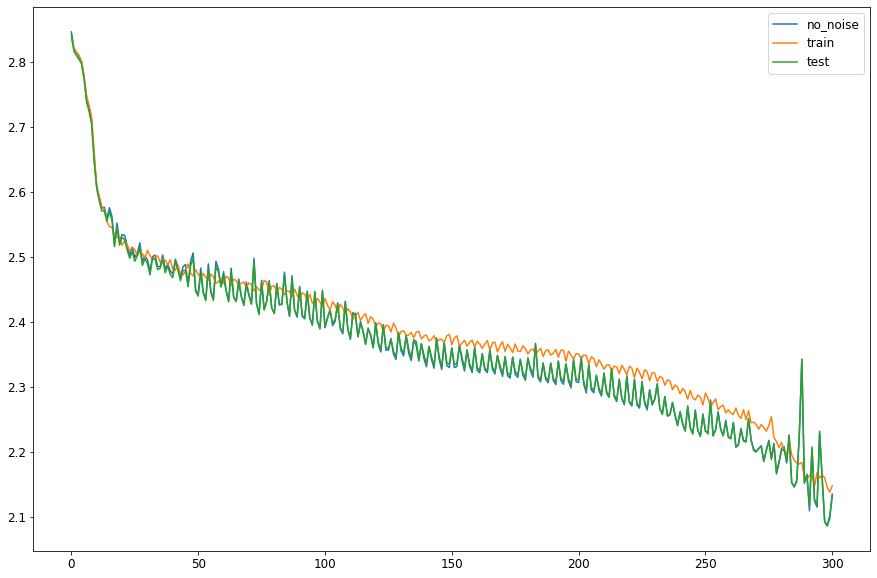

In [0]:
fig, ax = plt.subplots(1, figsize=(15,10))

ax.plot(no_noise_losses)
ax.plot(train_losses)
ax.plot(test_losses)
ax.legend(['no_noise', 'train', 'test'])

# Save model

In [0]:
flow_depth = 4

In [0]:
model_name = f"combi_flow2_4_3"
flow_model_path = f"{root_path}/plot_notebooks/models_for_plots/{model_name}"

In [15]:
with open(flow_model_path, 'wb') as f:
    pickle.dump(results_dict, f)

NameError: ignored

In [0]:
model_name

'combi_flow2_4_3'

# Visualize model

In [0]:
flow_depth=48

In [0]:
model_name = f"rotating_two_moons_combi_{flow_depth}"
flow_model_path = f"{root_path}/plot_notebooks/models_for_plots/{model_name}"

In [0]:
with open(flow_model_path, 'rb') as f:
    loaded_dict = pickle.load(f)

normalizing_flow = loaded_dict['model']

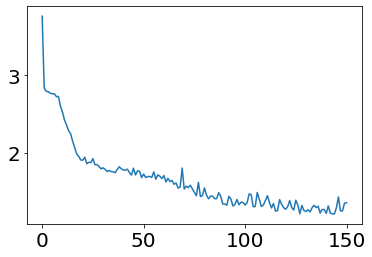

In [45]:
plt.plot(loaded_dict['logs']['test'])

In [46]:
loaded_dict['settings']

{'batch_size': 50000,
 'batchnorm_momentum': 0.1,
 'c_net_depth': 10,
 'c_net_h_dim': 18,
 'clipped_adam': 10,
 'context_dropout': None,
 'context_n_depth': 4,
 'context_n_h_dim': 10,
 'coupling_dropout': None,
 'data_size': 100000,
 'epochs': 1500,
 'flow_depth': 48,
 'l2_reg': None,
 'problem_dim': 2,
 'rich_context_dim': 5}

In [0]:
# Load data
from DEwNF.utils import split_synthetic
batch_size = 500
data_size = 100000
cuda_exp = True
train_dataloader, test_dataloader, obs_scaler, context_scaler = split_synthetic(data_df, batch_size,
                                                    data_size, cuda_exp, random_state=None)

In [0]:
    scaled_theta = torch.tensor(context_scaler.transform([[0]]))
    context = (scaled_theta).float().cuda()
    cond_dist = normalizing_flow.condition(context)

In [49]:
cond_dist.transforms

[ConditionedAffineCoupling2(),
 BatchNorm(),
 InvertedConditionedPlanar(),
 Permute(),
 BatchNorm(),
 ConditionedAffineCoupling2(),
 BatchNorm(),
 InvertedConditionedPlanar(),
 Permute(),
 BatchNorm(),
 ConditionedAffineCoupling2(),
 BatchNorm(),
 InvertedConditionedPlanar(),
 Permute(),
 BatchNorm(),
 ConditionedAffineCoupling2(),
 BatchNorm(),
 InvertedConditionedPlanar(),
 Permute(),
 BatchNorm(),
 ConditionedAffineCoupling2(),
 BatchNorm(),
 InvertedConditionedPlanar(),
 Permute(),
 BatchNorm(),
 ConditionedAffineCoupling2(),
 BatchNorm(),
 InvertedConditionedPlanar(),
 Permute(),
 BatchNorm(),
 ConditionedAffineCoupling2(),
 BatchNorm(),
 InvertedConditionedPlanar(),
 Permute(),
 BatchNorm(),
 ConditionedAffineCoupling2(),
 BatchNorm(),
 InvertedConditionedPlanar(),
 Permute(),
 BatchNorm(),
 ConditionedAffineCoupling2(),
 BatchNorm(),
 InvertedConditionedPlanar(),
 Permute(),
 BatchNorm(),
 ConditionedAffineCoupling2(),
 BatchNorm(),
 InvertedConditionedPlanar(),
 Permute(),
 Bat

In [0]:
def create_overlay(shape, bounds, flow_dist, obs_scaler):
    cm = matplotlib.cm.get_cmap('cividis')
    
    nlats, nlons = shape
    
    lats_array = torch.linspace(start=bounds[1][0], end=bounds[0][0], steps=nlats).float()
    lons_array = torch.linspace(start=bounds[0][1], end=bounds[1][1], steps=nlons).float()
    x, y = torch.meshgrid(lats_array, lons_array)

    points = torch.stack((x.reshape(-1), y.reshape(-1)), axis=1).cuda()
    scaled_points = torch.tensor(obs_scaler.transform(points.cpu())).float().cuda()
    with torch.no_grad():
        data = flow_dist.log_prob(scaled_points).reshape(nlats,nlons).cpu().detach().numpy()
    
    data = np.exp(data).T # this transpose should not be necesary
    data = (data - data.min()) / (data.max() - data.min())

    overlay = cm(data)
    return lons_array, lats_array, overlay, data

In [51]:

## interactive plot
plt.rcParams.update({'font.size': 20})
cond_two_moons = RotatingTwoMoonsConditionalSampler(noise=0.05)

def model_tester3(theta, flow, obs_scaler, context_scaler):
    flow.modules.eval()
    scaled_theta = torch.tensor(context_scaler.transform([[theta]]))
    context = (scaled_theta).float().cuda()
    cond_dist = flow.condition(context)
    x, _ = cond_two_moons.conditioned_sample(n_samples=512, theta=torch.tensor([theta]))
    bounds = [[-3,-2], [3,2]]
    _,_, _, data = create_overlay(shape = (800,800), bounds=bounds, flow_dist = cond_dist, obs_scaler=obs_scaler)  

    plt.figure(figsize=(12, 10))
    plt.scatter(x[:, 0], x[:, 1], c='r', s=5, alpha=0.5, label="Observations")
    plt.xlim(bounds[0][0],bounds[1][0])
    plt.ylim(bounds[0][1],bounds[1][1])
    test = plt.imshow(data, cmap='cividis', extent=(bounds[1][0],bounds[0][0], bounds[1][1], bounds[0][1]), label="Target distribution")
    plt.legend(framealpha=0.3, fontsize=15, markerscale=6)
    plt.colorbar(test, shrink=0.6)
    plt.show()


interactive_plot = interactive(model_tester3,
                               theta=(0.,2*np.pi),
                               flow=fixed(normalizing_flow),
                               obs_scaler=fixed(obs_scaler),
                               context_scaler=fixed(context_scaler))
interactive_plot


# for 24 2.40 is really good

interactive(children=(FloatSlider(value=3.141592653589793, description='theta', max=6.283185307179586), Output…

In [0]:
with open(flow_model_path, 'rb') as f:
    loaded_dict = pickle.load(f)

In [0]:
loaded_flow = loaded_dict['model']

In [0]:
loaded_dict['settings']

{'batch_size': 50000,
 'batchnorm_momentum': 0.1,
 'c_net_depth': 10,
 'c_net_h_dim': 18,
 'clipped_adam': 10,
 'context_dropout': None,
 'context_n_depth': 4,
 'context_n_h_dim': 10,
 'coupling_dropout': None,
 'data_size': 100000,
 'epochs': 3000,
 'flow_depth': 4,
 'l2_reg': None,
 'problem_dim': 2,
 'rich_context_dim': 5}

In [0]:
def create_plot(axs, x, dist, trans_idx, trans_type, obs_scaler):
    bounds = [[-3,-2], [3,2]]
    _, _, _, data = create_overlay(shape = (200,200), bounds=bounds, flow_dist = dist, obs_scaler=obs_scaler)  
    axs.scatter(x[:, 0], x[:, 1], c='r', s=5, alpha=0.5, label="Observations")
    axs.set_xlim(-3,3)
    axs.set_ylim(-2,2)
    axs.set_title(f'After transformation number {trans_idx} ({trans_type})', fontsize=15)
    axs.legend(framealpha=0.3, fontsize=12, markerscale=6)
    
    colors = axs.imshow(data, cmap='cividis', extent=(3,-3, 2, -2))
    return colors
    

In [0]:
def rename_trans(name):
    if name == "ConditionedAffineCoupling2()":
        return "Conditioned Affine Coupling"
    if name == "Permute()":
        return "Permute"
    if name == "BatchNorm()":
        return "Batchnorm"
    if name == "InvertedConditionedPlanar()":
        return "Conditioned Planar Transformation"

def model_tester4(theta, flow):
    flow.modules.eval()
    scaled_theta = torch.tensor(context_scaler.transform([[theta]]))
    context = (scaled_theta).float().cuda()
    cond_dist = flow.condition(context)
    x, _= cond_two_moons.conditioned_sample(n_samples=512, theta=torch.tensor([theta]))
    bounds = [[-3,-2], [3,2]]
    n_trans = len(cond_dist.transforms)
    fig, axs = plt.subplots(((n_trans) // 2) +1 , 2,  figsize=(25,n_trans*5),gridspec_kw = {'wspace':0, 'hspace':0})

    colors = create_plot(axs[0, 0], x, cond_dist.base_dist.to_event(1), 0, 'Base distribution', obs_scaler)
    plt.colorbar(colors, ax=axs[0,0], shrink=0.8)
    for i in range(0, n_trans):
        temp_dist = TransformedDistribution(cond_dist.base_dist, cond_dist.transforms[0:i+1])
        trans_type = rename_trans(cond_dist.transforms[i].__str__())
        colors = create_plot(axs[(i+1) // 2, (i+1) % 2 ], x, temp_dist, i+1, trans_type, obs_scaler)
        plt.colorbar(colors, ax=axs[(i+1) // 2, (i+1) % 2 ],shrink=0.8)
    if n_trans % 2 == 0:
        fig.delaxes(axs[n_trans//2, 1])

interactive_plot = interactive(model_tester4,
                               theta=(0.,2*np.pi),
                               flow=fixed(normalizing_flow))
interactive_plot


interactive(children=(FloatSlider(value=3.141592653589793, description='theta', max=6.283185307179586), Output…

In [0]:

interactive_plot = interactive(model_tester4,
                               theta=(0.,2*np.pi),
                               moon=(0.,1.,1),
                               trans_1=(-4.,4.),
                               trans_2=(-4.,4.),
                               flow_dist=fixed(loaded_flow.dist))
interactive_plot


ValueError: ignored